In [48]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 4

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [53]:
time = np.arange(0, 100, 0.1)
label = np.sin(time) + np.square(np.cos(time)) - np.square(np.square(np.cos(time))) #+ np.random.normal(scale=0.1, size=len(time))

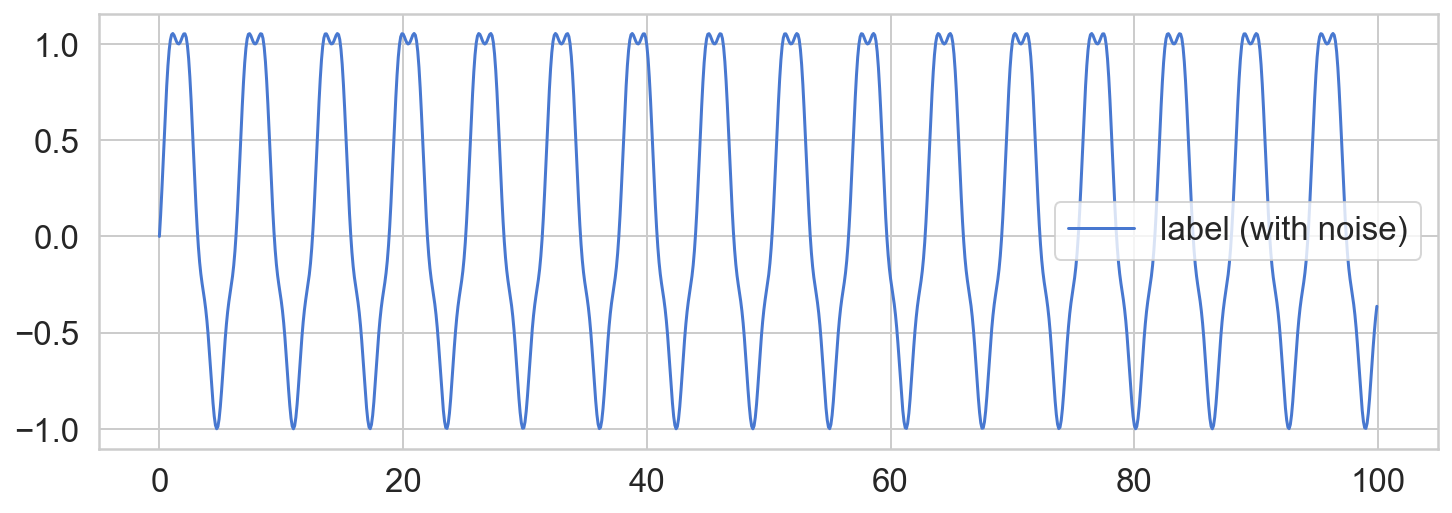

In [54]:
plt.plot(time, label, label='label (with noise)')
plt.legend()

In [55]:
df = pd.DataFrame(dict(label=label), index=time, columns=['label'])
df.head()

,label
0.0,0.000000
0.1,0.109701
0.2,0.236581
0.3,0.375225
0.4,0.518068


In [56]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

800 200


In [57]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [58]:
#time_steps = 10
time_steps = 3

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.label, time_steps)
X_test, y_test = create_dataset(test, test.label, time_steps)

print(X_train.shape, y_train.shape)

(797, 3, 1) (797,)


In [59]:
X_train[0]

array([[0.        ],
       [0.10970079],
       [0.23658099]])

In [60]:
df.head(11)

,label
0.0,0.000000
0.1,0.109701
0.2,0.236581
0.3,0.375225
0.4,0.518068
0.5,0.656444
0.6,0.781817
0.7,0.886995
0.8,0.967143
0.9,1.020422


In [61]:
y_train[0]

0.3752254873517554

In [62]:
model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.0001))

In [63]:
history = model.fit(
    X_train, y_train, 
    epochs=250, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

0
45/45 [==============================] - 0s 3ms/step - loss: 0.0305 - val_loss: 0.0333
Epoch 59/250
45/45 [==============================] - 0s 3ms/step - loss: 0.0303 - val_loss: 0.0331
Epoch 60/250
45/45 [==============================] - 0s 4ms/step - loss: 0.0301 - val_loss: 0.0329
Epoch 61/250
45/45 [==============================] - 0s 3ms/step - loss: 0.0300 - val_loss: 0.0327
Epoch 62/250
45/45 [==============================] - 0s 3ms/step - loss: 0.0298 - val_loss: 0.0325
Epoch 63/250
45/45 [==============================] - 0s 3ms/step - loss: 0.0296 - val_loss: 0.0323
Epoch 64/250
45/45 [==============================] - 0s 3ms/step - loss: 0.0294 - val_loss: 0.0322
Epoch 65/250
45/45 [==============================] - 0s 3ms/step - loss: 0.0292 - val_loss: 0.0320
Epoch 66/250
45/45 [==============================] - 0s 3ms/step - loss: 0.0291 - val_loss: 0.0318
Epoch 67/250
45/45 [==============================] - 0s 3ms/step - loss: 0.0289 - val_loss: 0.0315
Epoch 68/25

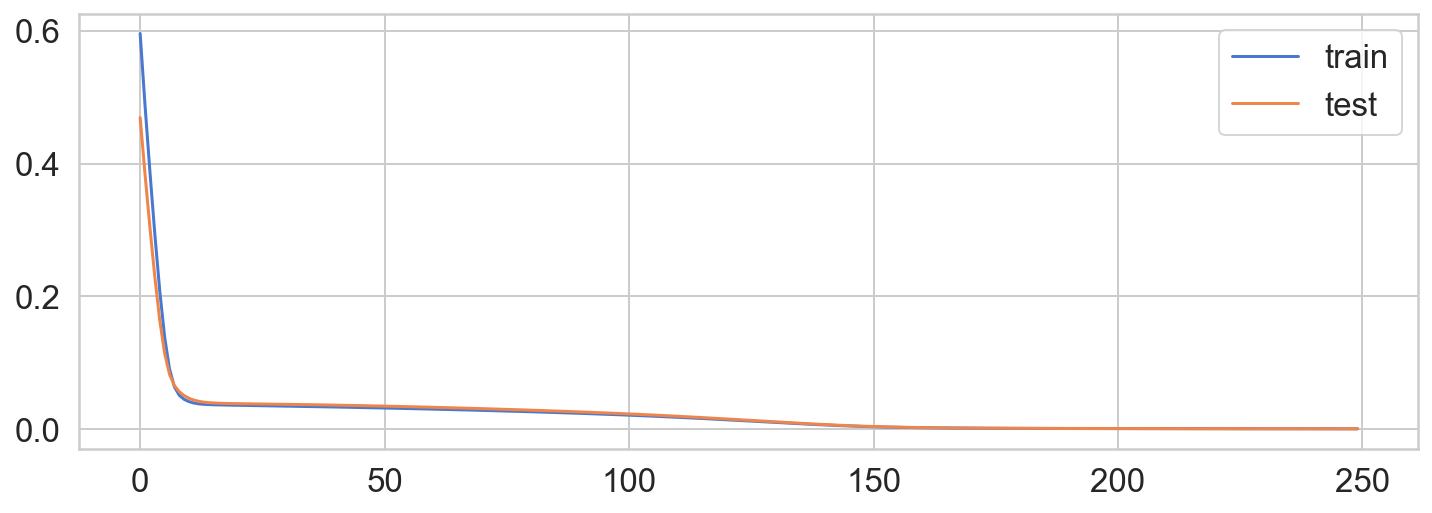

In [64]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [65]:
y_pred = model.predict(X_test)

In [66]:
y_pred.shape

(197, 1)

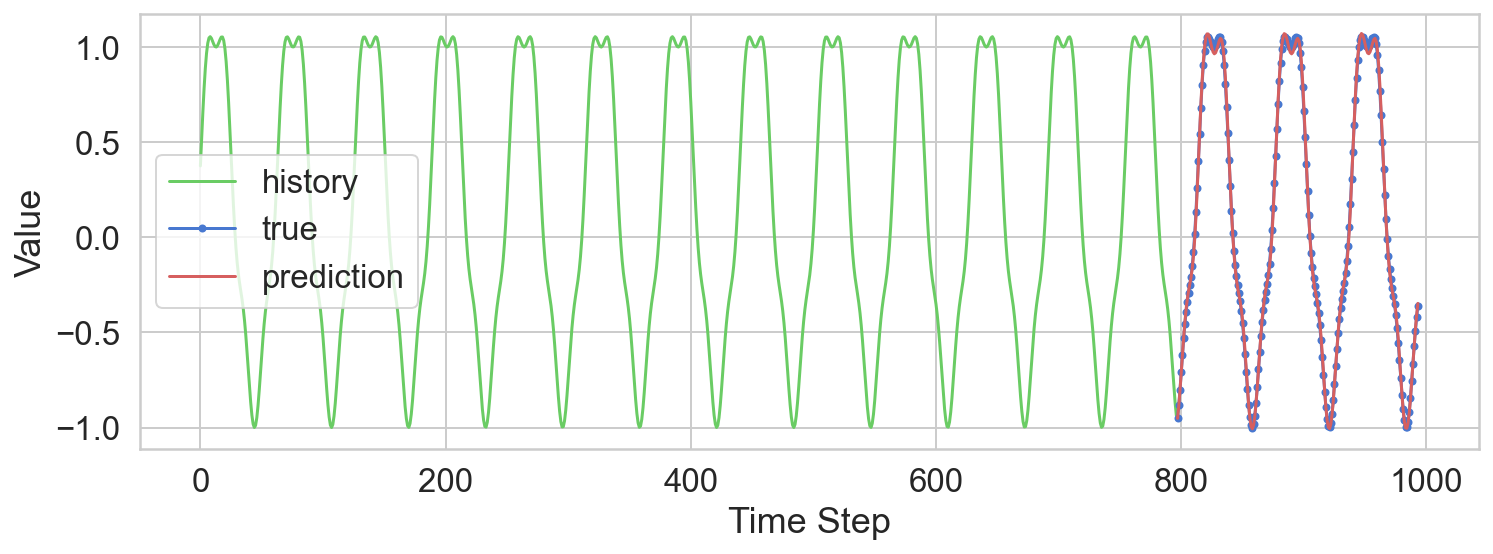

In [67]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

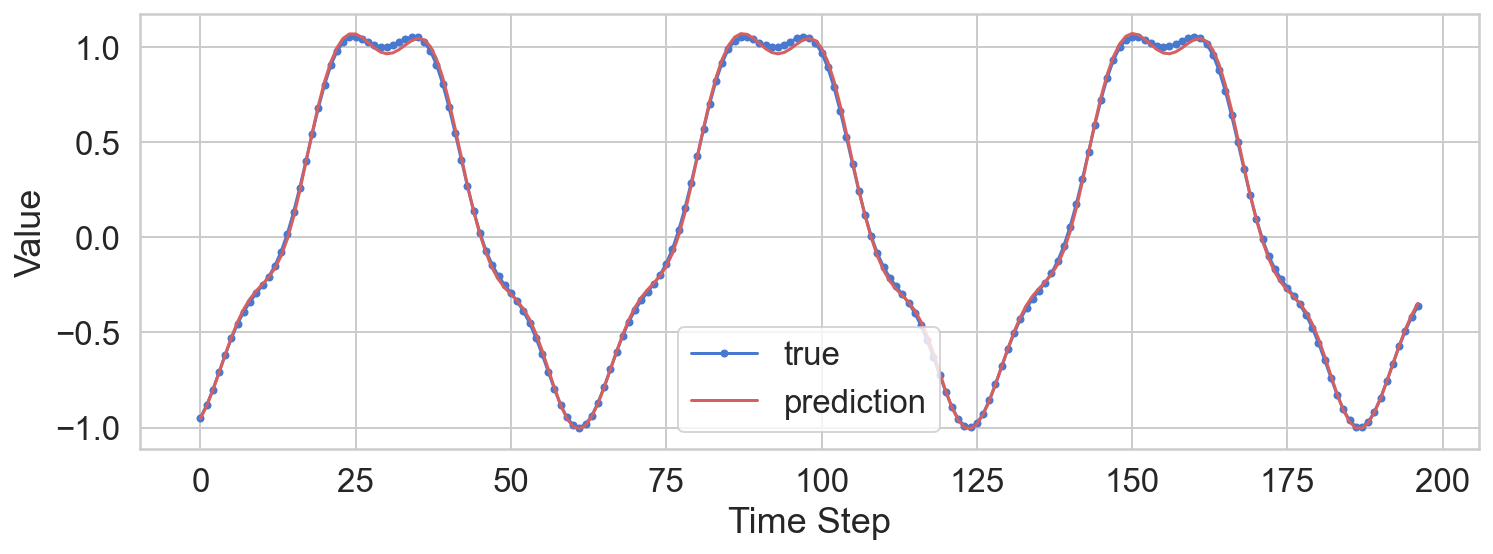

In [68]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();